In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, sample_subsequences, split_in_subsequences, add_mouse_columns_to_passive_trials
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel, initialise_model
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS, YOKED_TRAINING_COLS, MOUSE_COLS
from isaac.training import evaluate, training_loop, evaluate_saved_model
from isaac.sanity import class_proportions

In [4]:
BATCH_SIZE = 512
EPOCHS = 200
NORMALISE_DATA = True
STEP_SIZE = 2
SEQ_END = 1800

# Define common model, loss and optimizer

In [5]:
INPUT_DIM = len(YOKED_TRAINING_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 3     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

In [6]:
exp1_trials = read_dataset("data/yoked_trials_exp1.h5")
exp2_mass_trials = read_dataset("data/mass_trials_exp2.h5")
exp2_force_trials = read_dataset("data/force_trials_exp2.h5")

100%|██████████| 400/400 [00:07<00:00, 55.73it/s]


passive_trials = read_dataset("data/train_passive_trials.h5", n_trials=800)
passive_trials = add_mouse_columns_to_passive_trials(passive_trials)
passive_trials = [trial[:1801] for trial in passive_trials]

In [7]:
first_half = [trial[:1801] for trial in exp1_trials]
second_half = [trial[-1801:] for trial in exp1_trials]

exp1_trials = first_half + second_half

exp1_trials = split_in_subsequences(exp1_trials, seq_size=600)
exp2_mass_trials = split_in_subsequences(exp2_mass_trials, seq_size=600)
exp2_force_trials = split_in_subsequences(exp2_force_trials, seq_size=600)

In [8]:
yoked_trials = exp1_trials + exp2_force_trials + exp2_mass_trials

In [9]:
len(yoked_trials)

1086

In [10]:
np.random.seed(0)
indices = np.arange(len(yoked_trials))
train_indices = np.random.choice(indices, 900, replace=False)
val_indices = np.random.choice(list(set(indices) - set(train_indices)), 86, replace=False)
test_indices = list(set(indices) - set(train_indices) - set(val_indices))

In [11]:
train_trials = [yoked_trials[i] for i in train_indices]
val_trials = [yoked_trials[i] for i in val_indices]
test_trials = [yoked_trials[i] for i in test_indices]

In [12]:
len(train_trials), len(val_trials), len(test_trials)

(900, 86, 100)

# FORCE TRAINING  (Humans achieve 63% +- 21%)

## Read dataset and preprocess it

scaler = joblib.load("scalers/passive_force_scaler.sk")

In [22]:
loaders, scaler = prepare_dataset([train_trials, val_trials], class_columns=FORCE_CLASS_COLS, 
                                  training_columns=BASIC_TRAINING_COLS,
                                  batch_size=BATCH_SIZE, normalise_data=NORMALISE_DATA)

100%|██████████| 86/86 [00:00<00:00, 950.25it/s]


In [14]:
train_loader, val_loader = loaders

In [15]:
class_proportions(train_loader)
print()
class_proportions(val_loader)

[297 339 264]
Majority class:  0.37666666666666665

[26 34 26]
Majority class:  0.3953488372093023


## Define model, loss and optimizer

pretrained_model = ComplexRNNModel(*(16, 25, 4, 3), dropout=0.5)
pretrained_model.load_state_dict(torch.load("models/passive_force_model.pt"))
pretrained_model = pretrained_model.cuda()

class DualRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, dropout=0.):
        super(DualRNNModel, self).__init__()
        # RNN
        self.mouse = nn.GRU(7, 3, 2, batch_first=True, dropout=dropout)
        self.lstm = pretrained_model.lstm
        
        self.gru = nn.GRU(3 + 25, 12, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.fc = nn.Linear(12, output_dim)
    
    def forward(self, x):
        mouse =  x[:, :, -7:]
        objects = x[:, :, :-7]
        
        out_obj, _ = self.lstm(objects)
        out_mouse, _ = self.mouse(mouse)
        
        out = torch.cat((out_obj, out_mouse), dim=2)
        out, _ = self.gru(out)
        
        out = self.fc(out[:, -1, :]) 
        return out

len(BASIC_TRAINING_COLS)

In [25]:
model = ComplexRNNModel(*(16, 25, 4, 3), dropout=0.5)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model = model.cuda()

model, error, optimizer = initialise_model(network_dims, DROPOUT, lr=0.001)

## Train model and plot loss and accuracy

In [26]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, 
                                                           EPOCHS, seq_end=SEQ_END, step_size=STEP_SIZE)

Train_loss (0.12)	 Train_acc (74.44)	 Val_acc (39.53): 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


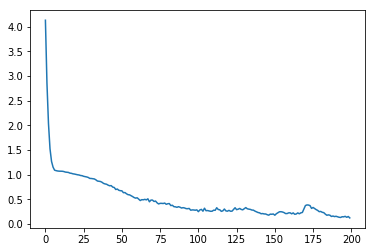

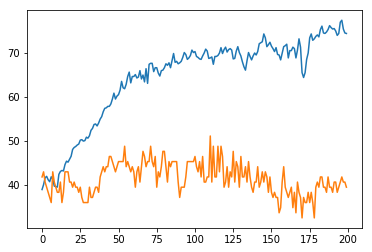

In [27]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [28]:
max(epoch_accuracies[1])

51.16279069767442

## Save model and scaler

In [29]:
torch.save(best_model.state_dict(), "models/yoked_force_model.pt")
joblib.dump(scaler, "scalers/yoked_force_scaler.sk")

['scalers/yoked_force_scaler.sk']

## Evaluate saved model

100%|██████████| 100/100 [00:00<00:00, 1142.13it/s]


Model's accuracy on test set: 34.0


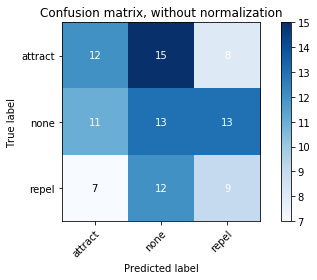

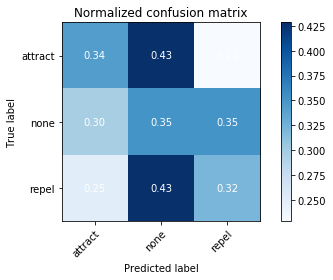

In [30]:
model_path = "models/yoked_force_model.pt"
scaler_path = "scalers/yoked_force_scaler.sk"
network_dims = (16, 25, 4, 3, 0.5)
class_columns = FORCE_CLASS_COLS

evaluate_saved_model(model_path, network_dims, None, BASIC_TRAINING_COLS,
                     class_columns, step_size=2, scaler_path=scaler_path, trials=test_trials,
                     arch=ComplexRNNModel)

# MASS TRAINING (Humans achieve 45% +- 20%)

## Read dataset and preprocess it

In [13]:
scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [14]:
loaders, scaler = prepare_dataset([train_trials, val_trials], training_columns=BASIC_TRAINING_COLS, 
                                  class_columns=MASS_CLASS_COLS, batch_size=BATCH_SIZE, 
                                  normalise_data=NORMALISE_DATA, scaler=scaler)

100%|██████████| 70/70 [00:00<00:00, 1071.67it/s]


In [15]:
train_loader, val_loader = loaders

In [16]:
class_proportions(train_loader)
class_proportions(val_loader)

[727 570 703]
Majority class:  0.3635
[27 17 26]
Majority class:  0.38571428571428573


## Define model, loss and optimizer

In [17]:
dual = ComplexRNNModel(*(16, 25, 4, 3), dropout=0.5)
dual.load_state_dict(torch.load("models/passive_mass_model.pt"))
error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(dual.parameters(), lr=0.001)
dual = dual.cuda()

## Train model and plot loss and accuracy

In [18]:
epoch_losses, epoch_accuracies, best_model = training_loop(dual, optimizer, error, train_loader, val_loader, EPOCHS, 
                                                           step_size=STEP_SIZE)

Train_loss (0.19)	 Train_acc (76.60)	 Val_acc (40.00): 100%|██████████| 200/200 [06:38<00:00,  2.01s/it]


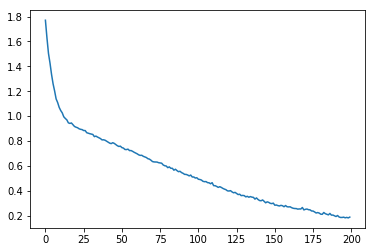

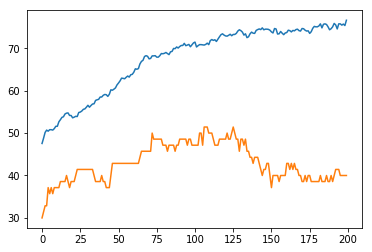

In [19]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [20]:
max(epoch_accuracies[1])

51.42857142857143

## Save model and scaler

In [21]:
torch.save(best_model.state_dict(), "models/yoked_mass_model.pt")
joblib.dump(scaler, "scalers/yoked_mass_scaler.sk")

['scalers/yoked_mass_scaler.sk']

## Load model and evaluate

100%|██████████| 101/101 [00:00<00:00, 886.57it/s]


Model's accuracy on test set: 45.54455445544554


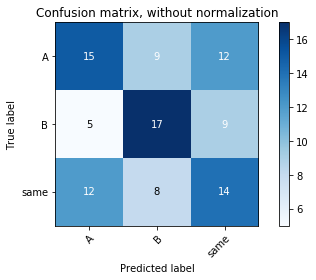

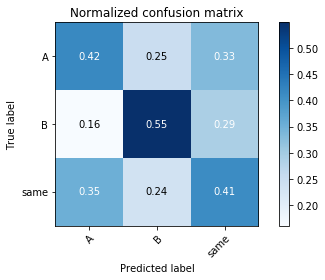

In [22]:
model_path = "models/yoked_mass_model.pt"
scaler_path = "scalers/yoked_mass_scaler.sk"
network_dims = (16, 25, 4, 3)
test_dataset_path = "data/test_passive_trials.h5"
class_columns = MASS_CLASS_COLS

evaluate_saved_model(model_path, network_dims, test_dataset_path, BASIC_TRAINING_COLS,
                     class_columns, step_size=STEP_SIZE, scaler_path=scaler_path, trials=test_trials)